# Notebook for quick analyisis of atomic coordinates using a SOAP based metric

In [1]:
#%reset
import numpy as np
from numpy import inf
from math import isnan
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text
%matplotlib inline

In [2]:
import sys
# https://github.com/BingqingCheng/ASAP
import asaplib

In [3]:
from asaplib.plot import plot_styles
plot_styles.set_nice_font()

# setups for making plots
from matplotlib import cm

#norm = cm.colors.Normalize(vmax=30, vmin=0)
cmap = cm.summer

In [4]:
# units
kb2kcalmol = 0.0019872036 # kb*K to kcal_mol

## load structures

In [5]:
from ase.io import read,write

In [6]:
press="20"
foldername = "P-"+press+"GPa/"

In [7]:
# load the known structures
dictknownframes = read(foldername+"dict-knownphases/knownphases-pressure-"+press+"GPa-combined.xyz",':')
dictknowntags=np.loadtxt(foldername+"dict-knownphases/knownphases-pressure-"+press+"GPa-combined.list", dtype="str")
ndictknownframes = len(dictknownframes)
print("loaded", ndictknownframes,"frames")

loaded 16 frames


In [8]:
# load the newly founded structures in this work
dictnewframes = read(foldername+"dict-newphases/newphases-pressure-"+press+"GPa-combined.xyz",':')
dictnewtags=np.loadtxt(foldername+"dict-newphases/newphases-pressure-"+press+"GPa-combined.list", dtype="str")
ndictnewframes = len(dictnewframes)
print("loaded", ndictnewframes,"frames")

loaded 12 frames


In [9]:
# combine the two sets
dicttags = [y for x in [dictknowntags,dictnewtags] for y in x] 
ndict = ndictknownframes + ndictnewframes

In [1]:
# load the structures found in RSS
rssframes = read(foldername+"result-complete/combined.xyz",':')
tags = np.loadtxt(foldername+"result-complete/ranking-complete", dtype="str")
nrssframes = len(rssframes)
print("loaded", nrssframes,"frames")

#  import some reference order parameter for the structures
enthalpy = np.array(tags[:,3],float)
volume = np.array(tags[:,2],float)
symmetry = tags[:,6]
frequency = np.array(tags[:,-1],float)
nforms = np.array(tags[:,4],int)
ranks = np.arange(nrssframes)
dividenforms = 1./nforms
ground_state_enthalpy = float(tags[0,3])

global_nforms = set(nforms)
print("searched using nforms=",global_nforms)

NameError: name 'read' is not defined

In [11]:
frames = dictknownframes + dictnewframes + rssframes
global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

nframes = len(frames)
print("a total of", nframes,"frames, with elements: ", global_species)

a total of 4718 frames, with elements:  [ 8 22]


# Build a kernel Matrix using DScribe lib

In [12]:
# if it has been computed before we can simply load it
eva = np.genfromtxt("saved-kernels/pressure-"+press+"GPa-linear-SOAP-kernel.out", dtype=float)
print("loaded","pressure-",press,"GPa-linear-SOAP-kernel.out")

### Alternatively, load the data coming from Glosim , creates a label list with each center's reference structure 
# load the kmatrix from glosim
#prefix = "pressure-"+press+"GPa-dict-complete-n8-l8-c4.0-g0.5_match_peratom"
#eva = np.genfromtxt(foldername+prefix+".k",skip_header=1)

loaded pressure- 20 GPa-linear-SOAP-kernel.out


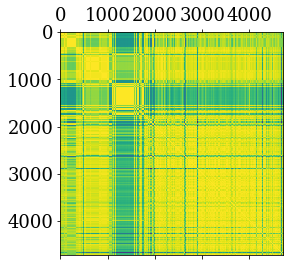

In [13]:
plt.matshow(eva)
plt.show()

# kernal PCA on environmental similarity

In [14]:
from asaplib.pca import kpca

In [15]:
proj = kpca(eva,10)

 - Centering the data 
  And now we build a projection 
Done, super quick. 


## kernel density estimation

In [16]:
from asaplib.kde import KDE

density_model = KDE()        
# fit density model to data
density_model.fit(proj)        
sigma_kij = density_model.bandwidth
rho = density_model.evaluate_density(proj)

Careful, you are trying to do density estimation for data in a D > 8 dimensional space
 ... you are warned !
[kde] Minimum bound = 0.0021 	 Rough estimate of h = 0.0210 	 Maximum bound = 0.0199
[kde] Bandwidth tolerance (xtol) set to precision of minimum bound : 0.00100 
[kde] Found log-likelihood maximum in 3 evaluations, h = 0.00248


## Quick plot of PCA results

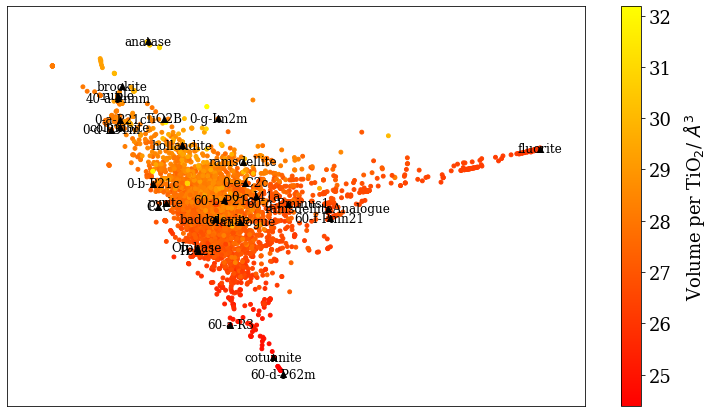

In [72]:
userho = False
useh = False
if (userho):
    plotcolor = rho[ndict:]
    colorlabel = 'local density of each data point'
elif (useh): # use entalpy as the color scheme
    plotcolor = enthalpy[:]
    colorlabel = 'Relative enthalpy per TiO$_2$ [Kcal/mol]'
else: # use molar volume as the color scheme
    plotcolor = volume[:]
    colorlabel = 'Volume per TiO$_2$/ $\AA^3$'
[ plotcolormin, plotcolormax ] = [ np.min(plotcolor),np.max(plotcolor) ]

d = [0,1]
#fig, ax = plt.subplots()
fig, ax = plot_styles.plot_density_map(proj[ndict:,d], plotcolor,
                xlabel=None, ylabel=None, 
                clabel=colorlabel, label=None,
                centers=None,
                psize=15,
                out_file=None, 
                title=None, 
                show=False, cmap='autumn',
                remove_tick=True,
                use_perc=False,
                rasterized = True,
                fontsize = 15,
                vmax = plotcolormax,
                vmin = plotcolormin)

texts = []
for x, y, s in zip(proj[:ndict,d[0]],proj[:ndict,d[1]],dicttags[:]):
    #print(x,y,s)
    texts.append(plt.text(x, y, s, ha='center', va='center', fontsize=12))
    
for i in range(ndict):
    ax.scatter(proj[i,d[0]],proj[i,d[1]],marker='^',c='black')
    #ax.annotate(dicttags[i], (proj[i,d[0]], proj[i,d[1]]))
    
ax.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

fig.set_size_inches(18.5*0.7, 10.5*0.7)
"""
adjust_text(texts, #only_move={'points':'', 'text':'x'},
            ax=ax, precision=0.001,
        expand_text=(1.01, 1.05), expand_points=(0, 0),
        force_text=(0.01, 0.01), force_points=(0.0, 0.0),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
"""
#plt.title('KPCA and clustering at '+press+' GPa')

plt.show()
#fig.savefig('figures/KPCA-molarV-'+press+'GPa.png')


## DBSCAN

In [18]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler # we can scale the data first

"""
simple clustering schemes using DBSCAN
"""

# #############################################################################
# Generate sample data
X = proj[:,0:10]
# #############################################################################
# Compute DBSCAN
veps = 0.003
vminsamples = 3
db = DBSCAN(eps=veps, min_samples=vminsamples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_db = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_ = list(labels_db).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels_db))

Estimated number of clusters: 159
Estimated number of noise points: 2397
Silhouette Coefficient: 0.128


## Analysis of the properties of each cluster

In [19]:
from asaplib.cluster import get_cluster_size, get_cluster_properties
[ unique_labels, cluster_size ]  = get_cluster_size(labels_db[ndict:])
[ unique_labels, cluster_avg_enthalpy ]  = get_cluster_properties(labels_db[ndict:],enthalpy[:],'mean')
[ unique_labels, cluster_min_enthalpy ]  = get_cluster_properties(labels_db[ndict:],enthalpy[:],'min')
[ unique_labels, cluster_avg_nforms ]  = get_cluster_properties(labels_db[ndict:],nforms[:],'mean')
[ unique_labels, cluster_avg_molarvolume ]  = get_cluster_properties(labels_db[ndict:],volume[:],'mean')
[ unique_labels, cluster_symmetry ]  = get_cluster_properties(labels_db[ndict:],symmetry[:],'mode')

## make plots of the KPCA + clustering

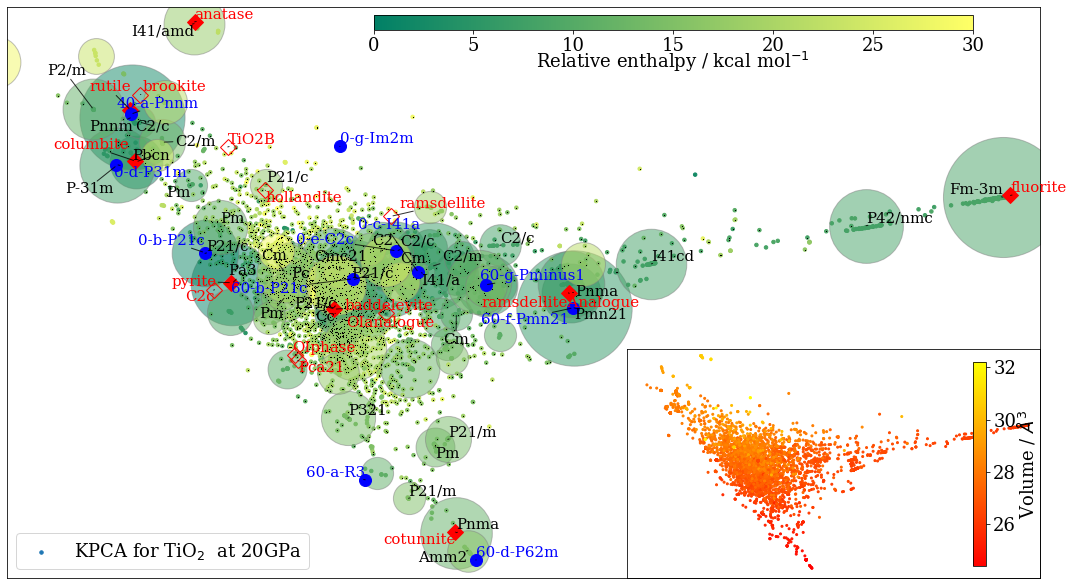

In [26]:
# make plot
d = [0,1]
[ unique_labels, cluster_x ]  = get_cluster_properties(labels_db[ndict:],proj[ndict:,d[0]],'mean')
[ unique_labels, cluster_y ]  = get_cluster_properties(labels_db[ndict:],proj[ndict:,d[1]],'mean')

maxe = 30.

fig, ax = plt.subplots()
texts = []

# all unknown structures
cset1 = ax.scatter(proj[ndict:, d[0]], proj[ndict:, d[1]],  c=enthalpy[:],
            cmap=cm.get_cmap(cmap),vmin=0,vmax=maxe, marker='o', s=12, label="KPCA for TiO$_2$  at "+press+ "GPa")
ax.legend(loc='lower left')

cbaxes = fig.add_axes([0.4, 0.85, 0.45, 0.02])
cbar=fig.colorbar(cset1, cax=cbaxes, orientation='horizontal')
cbar.ax.set_xlabel('Relative enthalpy / kcal mol$^{-1}$',labelpad=-5)

# plot the clusters with size propotional to population
# use the average enthalpy for the color scale
cluster_colors = [cmap(cluster_avg_enthalpy[each]/maxe)
          for each in unique_labels]
for k, col in zip(unique_labels, cluster_colors):
    ms = 20.0*(np.log(cluster_size[k]))
    if (k >=0 and cluster_size[k]>4):
        ax.plot(cluster_x[k],cluster_y[k], 'o', markerfacecolor=tuple(col), alpha =0.5,
            markeredgecolor='gray', markersize=ms)
        #print (cluster_x[k],cluster_y[k],cluster_size[k])
        # symmetry
        if (cluster_size[k]> 4 and cluster_avg_enthalpy[k]< 20
            and cluster_symmetry[k] != 'P-1' and cluster_symmetry[k] != 'P1') :
            texts.append(ax.text(cluster_x[k],cluster_y[k],cluster_symmetry[k],
                         ha='center', va='center', fontsize=15,color='black'))

    # the noisy points
    if k == -1:
        # Black removed and is used for noise instead.
        # Black used for noise.
        col = [0, 0, 0, 1]
        class_member_mask = (labels_db == k)
        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[ndict:, d[0]], xy[ndict:, d[1]], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.5)
    
# reference known structures
for i in range(ndictknownframes):
    if (labels_db[i] >= 0):
        ax.plot(proj[i,d[0]],proj[i,d[1]],marker='D',c='red', markersize=12)
    else: ax.plot(proj[i,d[0]],proj[i,d[1]],marker='D',markerfacecolor='none',
             markeredgecolor='red',markersize=12)
    texts.append(ax.text(proj[i,d[0]],proj[i,d[1]], dicttags[i], 
                         ha='center', va='center', fontsize=15,color='red'))

# reference new structures
for i in range(ndictknownframes+1,ndict):
    if (labels_db[i] >= 0):
        ax.plot(proj[i,d[0]],proj[i,d[1]],marker='o',c='blue', markersize=12)
    else: ax.plot(proj[i,d[0]],proj[i,d[1]],marker='o',markerfacecolor='none',
             markeredgecolor='blue',markersize=12)
    texts.append(ax.text(proj[i,d[0]],proj[i,d[1]], dicttags[i], 
                         ha='center', va='center', fontsize=15,color='blue'))

#plt.title('KPCA and clustering at '+press+' GPa')
fig.set_size_inches(18.5, 10.5)

adjust_text(texts,on_basemap=True,# only_move={'points':'', 'text':'x'},
                    expand_text=(1.01, 1.05), expand_points=(1.01, 1.05),
        force_text=(0.03, 0.5), force_points=(0.01, 0.25),
            ax=ax, precision=0.001,
            arrowprops=dict(arrowstyle="-", color='black', lw=1,alpha=0.8))

axislimit={}
axislimit[0] = [[-0.095,0.08],[-0.09,0.086]]
axislimit[20] = [[-0.06,0.092],[-0.099,0.086]]
axislimit[40] = [[-0.06,0.09],[-0.08,0.056]]
axislimit[60] = [[-0.05,0.089],[-0.075,0.045]]

al = axislimit[int(press)]
ax.set_xlim(al[0][0],al[0][1])
ax.set_ylim(al[1][0],al[1][1])

ax.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


#plt.tight_layout()

# embed another subplot
subpos = [0.6,0.00,0.4,0.4]
subax = plot_styles.add_subplot_axes(ax,subpos)

cset2 = subax.scatter(proj[ndict:, d[0]], proj[ndict:, d[1]],  c=volume[:],
            cmap='autumn', marker='o', s=4)

subax.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
subax.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
subax.set_xlim(al[0][0],al[0][1])
subax.set_ylim(al[1][0],al[1][1])
subcbaxes = fig.add_axes([0.85, 0.14, 0.01, 0.27])
subcbar=fig.colorbar(cset2, cax=subcbaxes)
subcbar.ax.set_ylabel('Volume / $\AA^3$',labelpad=-2)

fig.savefig('figures/KPCA-cluster-'+press+'GPa-v2.png', transparent=True)

In [27]:
from asaplib.cluster import output_cluster, output_cluster_sort

output_cluster("DBSCAN-"+press+"-GPa",labels_db,dicttags,tags)
output_cluster_sort("DBSCAN-"+press+"-GPa",labels_db,dicttags,tags)

0

## KRR for property prediction

### train test split

In [39]:
from asaplib.compressor import kernel_random_split

test_ratio=0.1
K_train, K_test, y_train, y_test, index_train, index_test = kernel_random_split(eva[ndict:,ndict:], enthalpy, test_ratio)

n_train = len(K_train)
n_test = len(K_test)

/home/bingqing/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### first do a FPS

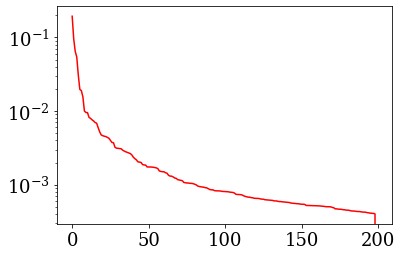

In [40]:
from asaplib.compressor import fps

# number of representative structures
nref = 200

ifps, dfps  = fps(K_train, nref, 0)
plt.semilogy(dfps,'r-')

In [41]:
write('FPS-xyz/fps-P'+press+'.xyz',frames[ifps[0]], append=False)
for i in ifps[1:]+ndict:
    write('FPS-xyz/fps-P'+press+'.xyz',frames[i], append=True)

In [42]:
K_MM = K_train[:,ifps][ifps]
K_NM = K_train[:,ifps]
K_TM = K_test[:,ifps]

### krr for enthalpy

In [43]:
from asaplib.fit import KRRSparse
from asaplib.fit import get_score

In [44]:
jitter = 1e-8
delta = np.std(y_train)/(np.trace(K_MM)/len(K_MM))
sigma = 0.1
krr = KRRSparse(jitter, delta, sigma)
# fit the model
krr.fit(K_MM,K_NM,y_train)

train score:  {'MAE': 0.7786377161234964, 'RMSE': 1.2489074627932486, 'SUP': 31.751716259067877, 'R2': 0.9704806667365977, 'CORR': 0.9860069899632988}
test score:  {'MAE': 0.7812128673297009, 'RMSE': 1.0479425833160054, 'SUP': 5.7186936842855065, 'R2': 0.9799841211274408, 'CORR': 0.9877045720773251}


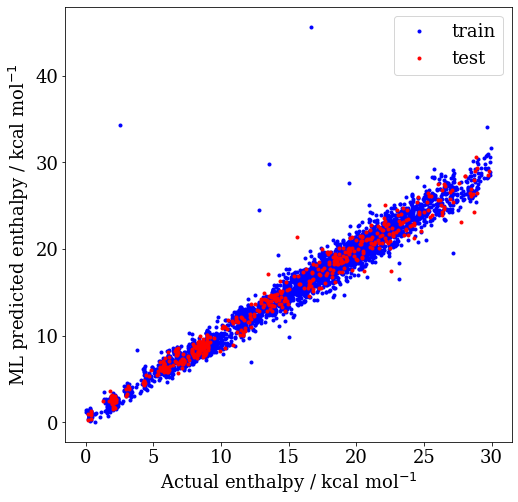

In [45]:
# get the predictions for train set
y_pred = krr.predict(K_NM)
# compute the CV score for the dataset
print("train score: ", get_score(y_pred,y_train))
# get the predictions for test set
y_pred_test = krr.predict(K_TM)
# compute the CV score for the dataset
print("test score: ", get_score(y_pred_test,y_test))
y_abs_error = np.sqrt((y_pred_test - y_test)**2.)

fig, ax = plt.subplots()
ax.plot(y_train, y_pred,'b.',label='train')
ax.plot(y_test, y_pred_test,'r.',label='test')
ax.legend()

ax.set_xlabel("Actual enthalpy / kcal mol$^{-1}$")
ax.set_ylabel("ML predicted enthalpy / kcal mol$^{-1}$")

fig.set_size_inches(8,8)

plt.show()

fig.savefig('figures/train-test-H-'+press+'GPa.png')


### learning curve

In [46]:
from asaplib.compressor import exponential_split, LCSplit,ShuffleSplit

In [47]:
# decide train sizes
lc_points = 20
train_sizes = exponential_split(nref, n_train-n_test, lc_points)
print("Learning curves using train sizes: ", train_sizes)
lc_stats = 12*np.ones(lc_points, dtype=int)
lc = LCSplit(ShuffleSplit, n_repeats=lc_stats,train_sizes=train_sizes,test_size=n_test, random_state=1)

Learning curves using train sizes:  [ 200  233  271  316  369  430  501  584  681  794  925 1078 1257 1465
 1708 1991 2321 2705 3153 3676]


In [48]:
lc_krr = KRRSparse(jitter, delta, sigma)

scores = {size:[] for size in train_sizes}
for lctrain,lctest in lc.split(y_train):
    Ntrain = len(lctrain)
    lc_K_NM = K_NM[lctrain,:]
    lc_y_train = y_train[lctrain]
    #lc_K_test = K_NM[lctest,:]
    lc_K_test = K_TM
    #lc_y_test = y_train[lctest]
    lc_y_test = y_test
    lc_krr.fit(K_MM,lc_K_NM,lc_y_train)
    lc_y_pred = lc_krr.predict(lc_K_test)
    scores[Ntrain].append(get_score(lc_y_pred,lc_y_test))

In [49]:
sc_name = 'RMSE'
Ntrains = []
avg_scores = []
avg_scores_error = []
for Ntrain, score in scores.items():
    avg = 0.
    var = 0.
    for sc in score:
        avg += sc[sc_name]
        var += sc[sc_name]**2.
    avg /= len(score)
    var /= len(score); var -= avg**2.
    avg_scores.append(avg)
    avg_scores_error.append(np.sqrt(var))
    Ntrains.append(Ntrain)

###  error estimation using bootstrap

In [51]:
from copy import deepcopy
# error estimation using bootstrap
subkrr = KRRSparse(jitter, delta,sigma)

bslist = []
nbs = 8
for ibs in range(nbs):
    idx = np.asarray(range(n_train))
    sbs = np.random.choice(idx, 2000, replace =False)
    #print sbs
    subK_NM = K_NM[sbs,:]
    suby_train = y_train[sbs]
    subkrr.fit(K_MM,subK_NM,suby_train)
    suby_pred = subkrr.predict(K_TM)
    bslist.append({"selection": sbs, "fit": deepcopy(subkrr),"prediction": suby_pred})

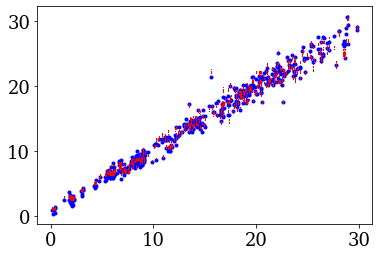

In [52]:
plt.plot(y_test, y_pred_test,'b.',label='test')
for ibs in range(nbs):
    plt.plot(y_test,bslist[ibs]['prediction'],'r,',label='subsample')
#plt.legend(loc='right')
plt.show()

In [53]:
# get the correlation coefficient between the true error and the predicted error
y_test_pred_error = np.zeros(n_test)
for i in range(n_test):
    y_test_pred_error[i] = np.std([bslist[ibs]['prediction'][i] for ibs in range(nbs)])
get_score(y_test_pred_error,y_abs_error)

{'CORR': 0.28156378685702155,
 'MAE': 0.6745114152614698,
 'R2': -0.8594449205342223,
 'RMSE': 0.9524729885770695,
 'SUP': 5.518002721965165}

[3.91192383 0.33146527]


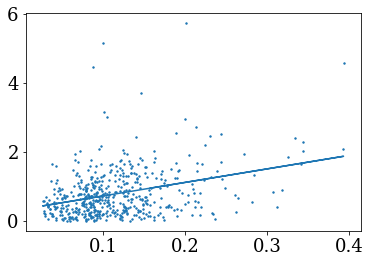

In [54]:
z = np.polyfit(y_test_pred_error,y_abs_error, 1)
print(z)
errorfit_enthalpy = np.poly1d(z)
plt.scatter(y_test_pred_error,y_abs_error, marker='o',s=2)
plt.plot(y_test_pred_error,errorfit_enthalpy(y_test_pred_error))

### prediction on the known possible structures in the dictionary

In [55]:
# prediction on the known possible structures in the dictionary
K_XM = eva[:ndict,index_train[ifps]+ndict]

y_enthalpy_prediction = krr.predict(K_XM)
suby_enthalpy_prediction = np.zeros((nbs,len(y_enthalpy_prediction)))
for ibs in range(nbs):
    suby_enthalpy_prediction[ibs,:]=bslist[ibs]['fit'].predict(K_XM)

In [56]:
y_prediction_result = np.zeros((ndict,7))
for i in range(ndict):
    cl = labels_db[i]
    y_prediction_result[i,0] = i
    y_prediction_result[i,-1] = cl
    if( cl >= 0): 
        # if the structure has been found, we take the mean of the enthalpy of the cluster
        y_prediction_result[i,1] = cluster_min_enthalpy[labels_db[i]] # mean of enthalpy
        y_prediction_result[i,2] = cluster_avg_enthalpy[labels_db[i]] -cluster_min_enthalpy[labels_db[i]]
    else:
        # if the structure hasn't been found, we use the KRR to predict its enthalpy
        y_prediction_result[i,1] = y_enthalpy_prediction[i] # mean of enthalpy
        y_prediction_result[i,2] = errorfit_enthalpy(np.std(suby_enthalpy_prediction[:,i])) # error estimate of enthalpy  
    
    
    print(i,cl,  dicttags[i], y_prediction_result[i,[1,2]])

0 0 anatase [17.244       0.28166667]
1 1 baddeleyite [4.237      0.09971429]
2 -1 brookite [8.99473216 0.91043197]
3 -1 C2c [6.50607019 1.13422372]
4 2 columbite [1.416      0.15528571]
5 3 cotunnite [11.321       0.20919444]
6 4 fluorite [3.803      4.73847407]
7 -1 hollandite [29.26252256  2.96951388]
8 -1 OIanalogue [3.04083759 1.32644524]
9 -1 OIphase [17.86184075  1.29899582]
10 -1 Pca21 [8.45349944 1.12829048]
11 5 pyrite [0.        0.3423871]
12 6 ramsdelliteAnalogue [5.222      0.19947368]
13 -1 ramsdellite [15.99379281  7.58715389]
14 7 rutile [1.377      0.66610937]
15 -1 TiO2B [24.55771117  2.77079234]
16 8 0-a-P21c [1.795   0.07725]
17 9 0-b-P21c [1.31       0.48778571]
18 10 0-c-I41a [5.426      0.51045455]
19 11 0-d-P31m [6.983      0.36204651]
20 12 0-e-C2c [5.888      0.19342105]
21 13 0-g-Im2m [10.044   0.0485]
22 7 40-a-Pnnm [1.377      0.66610937]
23 14 60-a-R3 [7.637      0.20733333]
24 15 60-b-P21c [2.84       0.25750877]
25 16 60-d-P62m [15.886    0.34225]
26 17 